In [1]:
%matplotlib inline

import argparse
import datetime
import json
import logging
import math
import os
import pickle
import time
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sparse
import torch
import torch.nn as nn
from torch.optim import Adam

U narednoj ćeliji se nalaze pomoćne funkcije i parametri koji će biti korišćeni u nastavku.

In [2]:
CORA_PARAMS = {
    "train_range": [0, 140],
    "val_range": [140, 640],
    "test_range": [1708, 2708],
    "num_features": 1433,
    "num_classes": 7
}


def generate_unique_name() -> str:
    """Generates (unique) name that is used for naming local runs.

    Returns:
        run_name (str): unique name.
    """
    run_name = datetime.datetime.utcnow().strftime("%y-%m-%d-%H-%M-%S-%f")

    return run_name


def make_dir_hierarchy() -> Dict[str, str]:
    """Creating all necessary directories that the current run will use.

    Returns:
        paths (argparse.Namespace): dictionary with created paths and other information.
    """
    run_name = generate_unique_name()

    # directory for storing information of current run
    runs_path = os.path.join("logs", run_name)
    os.makedirs(runs_path, exist_ok=True)

    # directory for storing log (including loss information)
    log_path = os.path.join(runs_path, "log")
    os.makedirs(log_path, exist_ok=True)

    # directory for storing checkpoints
    checkpoints_path = os.path.join(runs_path, "checkpoints")
    os.makedirs(checkpoints_path, exist_ok=True)

    paths = {
        "run_name": run_name,
        "runs_path": runs_path,
        "log_path": log_path,
        "checkpoints_path": checkpoints_path
    }

    return paths


def load_train_config(path: str) -> Dict[str, Any]:
    """Reads JSON config file and returns it.

    Args:
        path (str): config path.

    Returns:
        config (dict): config.
    """
    with open(path, "r") as f:
        config = json.load(f)

    return config


def read_from_binary(path: str):
    """Reads data from binary file.

    Args:
        path (str): path of the binary file.
    """
    with open(path, "rb") as f:
        data = pickle.load(f)

    return data


def normalize_features(features: Union[np.ndarray, sparse.csr.csr_matrix]):
    """Normalize each row to the unit row.

    Args:
        node_features (union): matrix of node features.

    Returns:
        node_features_normalized (union): normalized node features.
    """
    features_sum = np.array(np.sum(features, axis=1))

    features_inv_sum = np.squeeze(1.0 / features_sum)
    features_inv_sum[np.isinf(features_inv_sum)] = 1

    features_inv_sum_diag = sparse.diags(features_inv_sum)
    features_normalized = features_inv_sum_diag.dot(features)

    return features_normalized


def load_cora(data_dir: str, topology_normalization: str):
    """Loads CORA dataset.

    Args:
        data_dir (str): data directory.
        topology_normalization (str): how to normalize topology.

    Returns:
        node_features, node_labels, topology (tuple): pre-processed data.
    """
    # reading raw data
    node_features = read_from_binary(os.path.join(data_dir, "node_features.csr"))
    node_labels = read_from_binary(os.path.join(data_dir, "node_labels.npy"))
    adjacency_list = read_from_binary(os.path.join(data_dir, "adjacency_list.dict"))

    node_features = normalize_features(node_features)

    # making dense adjacency matrix ready for softmax to be applied
    topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
    topology = topology.todense().astype(np.float32)
    # adding loops
    topology += np.identity(topology.shape[0])

    if topology_normalization == "softmax":
        # making topology ready for softmax (-np.inf -> 0; 0 -> 1)
        topology[topology == 0] = -np.inf
        topology[topology == 1] = 0
    elif topology_normalization == "unit":
        topology = normalize_features(topology)

    return node_features, node_labels, topology


def calc_accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    if len(preds.size()) == 2:
        preds = torch.argmax(preds, dim=1)
    elif len(preds.size()) > 2:
        raise RuntimeError("Invalid prediction shape")

    num_hits = torch.sum(preds == labels)
    accuracy = num_hits / labels.size(0)

    return accuracy

In [3]:
class DropoutWrapper(nn.Module):
    def __init__(self, fn: nn.Module, dropout_prob: float):
        super().__init__()

        self._fn = fn
        self._activation = nn.ReLU()
        self._dropout = nn.Dropout(dropout_prob)

    def forward(self, data):
        topology = data[1]
        output = self._fn(data)[0]
        output = self._dropout(self._activation(output))

        return output, topology


class GraphConvolution(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)

        self._init_params()

    def _init_params(self):
        std = 1.0 / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-std, std)
        if self.bias is not None:
            self.bias.data.uniform_(-std, std)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        x, topology = data
        support = torch.matmul(x, self.weight)
        output = torch.matmul(topology, support)

        if self.bias is not None:
            output += self.bias

        return output, topology


class GCN(nn.Module):
    def __init__(self, num_features_per_layer: List[int], dropout_prob: float):
        super().__init__()

        layers = []
        for prev, curr in zip(num_features_per_layer[:-1: 2], num_features_per_layer[1::2]):
            layers.append(DropoutWrapper(GraphConvolution(prev, curr), dropout_prob))
        layers.append(GraphConvolution(num_features_per_layer[-2], num_features_per_layer[-1]))

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        output = self._net(data)

        return output

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, intermediate_dim: List[int], output_dim: int):
        super().__init__()

        layers = []
        if len(intermediate_dim) == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            num_neurons = [input_dim] + intermediate_dim
            for prev, curr in zip(num_neurons[:-1], num_neurons[1:]):
                layers.append(nn.Linear(prev, curr))
                layers.append(nn.GELU())

            layers.append(nn.Linear(num_neurons[-1], output_dim))

        self._net = nn.Sequential(*layers)
        self._softmax = nn.Softmax(dim=-1)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        x, topology = data
        output = self._net(x)
        output = self._softmax(output)

        return output, topology

In [5]:
class GATLayer(nn.Module):
    """Class for GAT's elementary layer."""

    def __init__(self, num_in_features: int, num_out_features: int, num_heads: int, dropout_prob: float = 0.6,
                 to_aggregate_heads: bool = False, add_skip_connection: bool = True):
        """Constructor of GAT layer.

        Args:
            num_in_features (int): number of input features.
            num_out_features (int): number of output features.
            num_heads (int): number of attention heads.
            dropout_prob (float): probability of dropout.
            to_aggregate_heads (bool): aggregate features of attention heads (True) or not (False).
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        # head's dimension
        self._head_dim = 1
        self._num_in_features = num_in_features
        self._num_out_features = num_out_features
        self._num_heads = num_heads
        self._to_aggregate_heads = to_aggregate_heads
        self._add_skip_connection = add_skip_connection

        # not used during training - only for logging/visualization
        self._attention_weights = None

        # projection and scoring mappings
        self._proj_param = nn.Parameter(torch.Tensor(num_heads, num_in_features, num_out_features))
        self._scoring_source = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))
        self._scoring_target = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))

        if add_skip_connection:
            self._skip_proj = nn.Linear(num_in_features, num_heads * num_out_features, bias=False)

        self._activation = nn.LeakyReLU(negative_slope=0.2)
        self._softmax = nn.Softmax(dim=-1)
        self._dropout = nn.Dropout(p=dropout_prob)

        self._init_params()

    def _init_params(self):
        nn.init.xavier_uniform_(self._proj_param)
        nn.init.xavier_uniform_(self._scoring_source)
        nn.init.xavier_uniform_(self._scoring_target)

    def _aggregate_heads(self, attention_weights: torch.Tensor, in_node_features: torch.Tensor, out_node_features: torch.Tensor) \
            -> torch.Tensor:
        """Aggregate features of all attention heads.

        Aggregation is either cocatenation or mean.

        Args:
            attention_weights (torch.Tensor): attention coefficients.
            in_node_features (torch.Tensor): input node features.
            out_node_features (torch.Tensor): output node features.

        Returns:
            out_node_features (torch.Tensor): aggregated node features.
        """
        # for later inspection
        self._attention_weights = attention_weights

        # view will raise an exception if underlying memory isn't contiguous
        if not out_node_features.is_contiguous():
            out_node_features = out_node_features.contiguous()

        if self._add_skip_connection:
            if out_node_features.size(-1) == in_node_features.size(-1):
                out_node_features += in_node_features.unsqueeze(1)
            else:
                out_node_features += self._skip_proj(in_node_features).view(-1, self._num_heads, self._num_out_features)

        if self._to_aggregate_heads:
            out_node_features = out_node_features.view(-1, self._num_heads * self._num_out_features)
        else:
            out_node_features = torch.mean(out_node_features, dim=self._head_dim)

        out_node_features = self._activation(out_node_features)

        return out_node_features

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            out_node_features, topology (tuple): output node features and graph topology.
        """
        in_node_features, topology = data
        num_nodes = in_node_features.shape[0]
        assert topology.shape == (num_nodes, num_nodes), "Adjacency matrix has invalid shape."

        in_node_features = self._dropout(in_node_features)
        node_features_proj = torch.matmul(in_node_features.unsqueeze(0), self._proj_param)
        node_features_proj = self._dropout(node_features_proj)

        edge_scores_source = torch.bmm(node_features_proj, self._scoring_source)
        edge_scores_target = torch.bmm(node_features_proj, self._scoring_target)
        edge_scores = self._activation(edge_scores_source + edge_scores_target.transpose(1, 2))
        attention_weights = self._softmax(edge_scores + topology)

        out_node_features = torch.bmm(attention_weights, node_features_proj)
        out_node_features = out_node_features.transpose(0, 1)

        out_node_features = self._aggregate_heads(attention_weights, in_node_features, out_node_features)

        return out_node_features, topology


class GAT(nn.Module):
    """Class for Graph Attention Network (GAT)."""

    def __init__(self, num_heads_per_layer: List[int], num_features_per_layer: List[int], dropout_prob: float = 0.6,
                 add_skip_connection: bool = True, **kwargs):
        """Constructor of GAT.

        Args:
            num_heads_per_layer (list): number of heads for each layer.
            num_features_per_layer (list): number of features for each layer.
            dropout_prob (float): probability of dropout layer used in GAT's layers.
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        num_layers = len(num_heads_per_layer)
        num_heads_per_layer = [1] + num_heads_per_layer

        layers = []
        for i in range(num_layers):
            layer = GATLayer(num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                             num_out_features=num_features_per_layer[i + 1],
                             num_heads=num_heads_per_layer[i + 1],
                             to_aggregate_heads=i < num_layers - 1,
                             dropout_prob=dropout_prob,
                             add_skip_connection=add_skip_connection)
            layers.append(layer)

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            output (tuple): output node features and graph topology.
        """
        output = self._net(data)

        return output

In [6]:
class Trainer:
    """Class used for training the GAT."""

    def __init__(self, config: Dict[str, Any]):
        """Constructor.

        Args:
            config (dict): configuration of the training, inference and the model.
        """
        self._paths = make_dir_hierarchy()
        self._setup_logger(os.path.join(self._paths["log_path"], "log.txt"))

        with open(os.path.join(self._paths["runs_path"], "config.json"), "w") as f:
            json.dump(config, f, indent=4)

        self._config = config
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        topology_normalization = "unit" if config["model_name"] == "GCN" else "softmax"
        node_features, node_labels, topology = load_cora(config["data_dir"], topology_normalization)
        self._node_features = torch.tensor(node_features.todense(), device=self._device)
        self._node_labels = torch.tensor(node_labels, dtype=torch.long, device=self._device)
        self._topology = torch.tensor(topology, dtype=torch.float32, device=self._device)
        self._indices = {
            "train": torch.arange(*CORA_PARAMS["train_range"], dtype=torch.long, device=self._device),
            "val": torch.arange(*CORA_PARAMS["val_range"], dtype=torch.long, device=self._device),
            "test": torch.arange(*CORA_PARAMS["test_range"], dtype=torch.long, device=self._device)
        }

        if config["model_name"] == "GCN":
            self._model = GCN(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "GAT":
            self._model = GAT(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "MLP":
            self._model = MLP(**config["model_kwargs"]).to(self._device)

        self._criterion = nn.CrossEntropyLoss()
        self._optimizer = Adam(self._model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

        # saves all metrics and losses during training
        self._aggregator = {}

    def _update_aggregator(self, name: str, value: float) -> None:
        aggregated_values = self._aggregator.get(name, [])
        aggregated_values.append(value)
        self._aggregator[name] = aggregated_values

    def _setup_logger(self, log_path: str) -> None:
        """Setup logging to print logs to both file and stdout.

        Timestamps are in GMT format due to lexicographic order. Example: 22-01-27-21-09-48.

        Args:
            log_path (str): path of log file.
        """
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s: [%(levelname)s] %(message)s",
            datefmt="%y-%m-%d %H:%M:%S",
            handlers=[
                logging.FileHandler(log_path),
                logging.StreamHandler()
            ]
        )
        logging.Formatter.converter = time.gmtime

    def _prepare_log(self, epoch, ce, acc, name):
        epoch_length = len(str(self._config["epochs"]))
        total_length = len(f"epoch=[{self._config['epochs']}/{self._config['epochs']}]:")
        epoch_log = f"epoch=[{epoch:>{epoch_length}}/{self._config['epochs']}]:"
        ce_log = f"CE_{name}={ce:.5f}"
        acc_log = f"ACC_{name}={acc:.2%}"
        log = f"{epoch_log:<{total_length}} {ce_log:>16} {acc_log:>16}"

        return log

    def run_training(self):
        train_labels = self._node_labels.index_select(0, self._indices["train"])
        train_indices = self._indices["train"]
        graph_data = (self._node_features, self._topology)

        for epoch in range(1, self._config["epochs"] + 1):
            self._model.train()
            self._optimizer.zero_grad()

            pred_labels = self._model(graph_data)[0].index_select(0, train_indices)
            loss = self._criterion(pred_labels, train_labels)
            accuracy = calc_accuracy(pred_labels, train_labels)

            logging.info(self._prepare_log(epoch, loss.item(), accuracy, "train"))
            self._update_aggregator("CE_train", (epoch, loss.item()))
            self._update_aggregator("ACC_train", (epoch, accuracy))

            loss.backward()
            self._optimizer.step()

            if epoch % self._config["ckpt_freq"] == 0:
                self._dump_model(epoch)

            if epoch == 1 or epoch % self._config["val_freq"] == 0:
                self._run_val(epoch)

            if epoch == 1 or epoch % self._config["test_freq"] == 0:
                self._run_test(epoch)

    def _run_val(self, epoch: int):
        val_labels = self._node_labels.index_select(0, self._indices["val"])
        val_indices = self._indices["val"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, val_indices)
        loss = self._criterion(pred_labels, val_labels)
        accuracy = calc_accuracy(pred_labels, val_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "val"))
        self._update_aggregator("CE_val", (epoch, loss.item()))
        self._update_aggregator("ACC_val", (epoch, accuracy))

    def _run_test(self, epoch: int):
        test_labels = self._node_labels.index_select(0, self._indices["test"])
        test_indices = self._indices["test"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, test_indices)
        loss = self._criterion(pred_labels, test_labels)
        accuracy = calc_accuracy(pred_labels, test_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "test"))
        self._update_aggregator("CE_test", (epoch, loss.item()))
        self._update_aggregator("ACC_test", (epoch, accuracy))

    def _dump_model(self, epoch: int) -> None:
        """Dumps current checkpoint.

        Args:
            epoch (int): current epoch.
        """
        ckpt_path = os.path.join(self._paths["checkpoints_path"], f"gat_{epoch}.ckpt")
        torch.save(self._model.state_dict(), ckpt_path)

    @property
    def aggregator(self) -> Dict[str, Any]:
        """Getter for aggregator."""
        return self._aggregator

    @property
    def model(self) -> nn.Module:
        """Getter for model."""
        return self._model

In [7]:
config_gcn = {
    "model_name": "GCN",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_features_per_layer": [1433, 16, 7],
        "dropout_prob": 0.5
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gcn = Trainer(config_gcn)
trainer_gcn.run_training()

C:\Users\kostag\Anaconda3\envs\mlmatf-gnn\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
22-06-15 21:35:58: [INFO] epoch=[  1/200]: CE_train=1.95729 ACC_train=12.86%
22-06-15 21:35:58: [INFO] epoch=[  1/200]:   CE_val=1.93035   ACC_val=12.20%
22-06-15 21:35:58: [INFO] epoch=[  1/200]:  CE_test=1.92404  ACC_test=13.00%
22-06-15 21:35:58: [INFO] epoch=[  2/200]: CE_train=1.95062 ACC_train=14.29%
22-06-15 21:35:58: [INFO] epoch=[  3/200]: CE_train=1.95127 ACC_train=13.57%
22-06-15 21:35:58: [INFO] epoch=[  4/200]: CE_train=1.93917 ACC_train=12.86%
22-06-15 21:35:58: [INFO] epoch=[  5/200]: CE_train=1.94236 ACC_train=11.43%
22-06-15 21:35:58: [INFO] epoch=[  6/200]: CE_train=1.92335 ACC_train=17.14%
22-06-

22-06-15 21:36:01: [INFO] epoch=[ 85/200]: CE_train=0.83079 ACC_train=90.00%
22-06-15 21:36:01: [INFO] epoch=[ 86/200]: CE_train=0.80900 ACC_train=91.43%
22-06-15 21:36:01: [INFO] epoch=[ 87/200]: CE_train=0.79673 ACC_train=87.14%
22-06-15 21:36:01: [INFO] epoch=[ 88/200]: CE_train=0.76112 ACC_train=92.86%
22-06-15 21:36:01: [INFO] epoch=[ 89/200]: CE_train=0.75238 ACC_train=90.71%
22-06-15 21:36:01: [INFO] epoch=[ 90/200]: CE_train=0.75593 ACC_train=90.71%
22-06-15 21:36:01: [INFO] epoch=[ 90/200]:   CE_val=1.12312   ACC_val=79.20%
22-06-15 21:36:01: [INFO] epoch=[ 90/200]:  CE_test=1.08085  ACC_test=81.20%
22-06-15 21:36:01: [INFO] epoch=[ 91/200]: CE_train=0.71204 ACC_train=92.86%
22-06-15 21:36:01: [INFO] epoch=[ 92/200]: CE_train=0.72071 ACC_train=95.71%
22-06-15 21:36:02: [INFO] epoch=[ 93/200]: CE_train=0.72134 ACC_train=91.43%
22-06-15 21:36:02: [INFO] epoch=[ 94/200]: CE_train=0.76000 ACC_train=90.00%
22-06-15 21:36:02: [INFO] epoch=[ 95/200]: CE_train=0.70334 ACC_train=93.57%

22-06-15 21:36:04: [INFO] epoch=[174/200]: CE_train=0.38238 ACC_train=97.14%
22-06-15 21:36:04: [INFO] epoch=[175/200]: CE_train=0.40920 ACC_train=97.14%
22-06-15 21:36:04: [INFO] epoch=[176/200]: CE_train=0.36048 ACC_train=97.86%
22-06-15 21:36:05: [INFO] epoch=[177/200]: CE_train=0.36887 ACC_train=95.71%
22-06-15 21:36:05: [INFO] epoch=[178/200]: CE_train=0.33201 ACC_train=96.43%
22-06-15 21:36:05: [INFO] epoch=[179/200]: CE_train=0.37548 ACC_train=95.00%
22-06-15 21:36:05: [INFO] epoch=[180/200]: CE_train=0.38620 ACC_train=95.71%
22-06-15 21:36:05: [INFO] epoch=[180/200]:   CE_val=0.79408   ACC_val=79.20%
22-06-15 21:36:05: [INFO] epoch=[180/200]:  CE_test=0.74503  ACC_test=82.10%
22-06-15 21:36:05: [INFO] epoch=[181/200]: CE_train=0.39123 ACC_train=97.14%
22-06-15 21:36:05: [INFO] epoch=[182/200]: CE_train=0.36381 ACC_train=95.71%
22-06-15 21:36:05: [INFO] epoch=[183/200]: CE_train=0.33806 ACC_train=97.14%
22-06-15 21:36:05: [INFO] epoch=[184/200]: CE_train=0.34817 ACC_train=98.57%

In [8]:
config_gat = {
    "model_name": "GAT",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.005,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_heads_per_layer": [8, 1],
        "add_skip_connection": False,
        "num_features_per_layer": [1433, 8, 7],
        "dropout_prob": 0.6
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gat = Trainer(config_gat)
trainer_gat.run_training()

22-06-15 21:36:06: [INFO] epoch=[  1/200]: CE_train=1.94598 ACC_train=12.86%
22-06-15 21:36:07: [INFO] epoch=[  1/200]:   CE_val=1.94559   ACC_val=36.80%
22-06-15 21:36:07: [INFO] epoch=[  1/200]:  CE_test=1.94561  ACC_test=34.80%
22-06-15 21:36:08: [INFO] epoch=[  2/200]: CE_train=1.94540 ACC_train=30.00%
22-06-15 21:36:09: [INFO] epoch=[  3/200]: CE_train=1.94459 ACC_train=36.43%
22-06-15 21:36:10: [INFO] epoch=[  4/200]: CE_train=1.94338 ACC_train=55.00%
22-06-15 21:36:11: [INFO] epoch=[  5/200]: CE_train=1.94332 ACC_train=43.57%
22-06-15 21:36:11: [INFO] epoch=[  6/200]: CE_train=1.94094 ACC_train=58.57%
22-06-15 21:36:12: [INFO] epoch=[  7/200]: CE_train=1.94002 ACC_train=52.86%
22-06-15 21:36:13: [INFO] epoch=[  8/200]: CE_train=1.93854 ACC_train=59.29%
22-06-15 21:36:14: [INFO] epoch=[  9/200]: CE_train=1.93733 ACC_train=55.71%
22-06-15 21:36:14: [INFO] epoch=[ 10/200]: CE_train=1.93563 ACC_train=53.57%
22-06-15 21:36:15: [INFO] epoch=[ 10/200]:   CE_val=1.93666   ACC_val=76.60%

22-06-15 21:37:22: [INFO] epoch=[ 90/200]: CE_train=1.10270 ACC_train=65.71%
22-06-15 21:37:23: [INFO] epoch=[ 90/200]:   CE_val=1.42759   ACC_val=81.20%
22-06-15 21:37:23: [INFO] epoch=[ 90/200]:  CE_test=1.40678  ACC_test=81.50%
22-06-15 21:37:23: [INFO] epoch=[ 91/200]: CE_train=1.01807 ACC_train=70.71%
22-06-15 21:37:24: [INFO] epoch=[ 92/200]: CE_train=1.11359 ACC_train=68.57%
22-06-15 21:37:25: [INFO] epoch=[ 93/200]: CE_train=1.05893 ACC_train=70.00%
22-06-15 21:37:26: [INFO] epoch=[ 94/200]: CE_train=1.08367 ACC_train=74.29%
22-06-15 21:37:27: [INFO] epoch=[ 95/200]: CE_train=1.13353 ACC_train=65.00%
22-06-15 21:37:27: [INFO] epoch=[ 96/200]: CE_train=1.08130 ACC_train=67.14%
22-06-15 21:37:28: [INFO] epoch=[ 97/200]: CE_train=1.03026 ACC_train=72.14%
22-06-15 21:37:29: [INFO] epoch=[ 98/200]: CE_train=1.13044 ACC_train=69.29%
22-06-15 21:37:30: [INFO] epoch=[ 99/200]: CE_train=1.09532 ACC_train=69.29%
22-06-15 21:37:30: [INFO] epoch=[100/200]: CE_train=1.09964 ACC_train=70.00%

22-06-15 21:38:37: [INFO] epoch=[179/200]: CE_train=0.68439 ACC_train=81.43%
22-06-15 21:38:38: [INFO] epoch=[180/200]: CE_train=0.83225 ACC_train=76.43%
22-06-15 21:38:38: [INFO] epoch=[180/200]:   CE_val=1.22653   ACC_val=79.80%
22-06-15 21:38:39: [INFO] epoch=[180/200]:  CE_test=1.20058  ACC_test=81.30%
22-06-15 21:38:39: [INFO] epoch=[181/200]: CE_train=0.76571 ACC_train=80.71%
22-06-15 21:38:40: [INFO] epoch=[182/200]: CE_train=0.74538 ACC_train=80.71%
22-06-15 21:38:41: [INFO] epoch=[183/200]: CE_train=0.79560 ACC_train=75.00%
22-06-15 21:38:41: [INFO] epoch=[184/200]: CE_train=0.76666 ACC_train=75.00%
22-06-15 21:38:42: [INFO] epoch=[185/200]: CE_train=0.73493 ACC_train=79.29%
22-06-15 21:38:43: [INFO] epoch=[186/200]: CE_train=0.96383 ACC_train=65.71%
22-06-15 21:38:44: [INFO] epoch=[187/200]: CE_train=0.77419 ACC_train=75.00%
22-06-15 21:38:44: [INFO] epoch=[188/200]: CE_train=0.87234 ACC_train=72.14%
22-06-15 21:38:45: [INFO] epoch=[189/200]: CE_train=0.79780 ACC_train=75.71%

In [9]:
config_mlp = {
    "model_name": "MLP",
    "data_dir": "data",
    "epochs": 100,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "input_dim": 1433,
        "intermediate_dim": [4096],
        "output_dim": 7
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_mlp = Trainer(config_mlp)
trainer_mlp.run_training()

22-06-15 21:38:55: [INFO] epoch=[  1/100]: CE_train=1.94592 ACC_train=15.00%
22-06-15 21:38:56: [INFO] epoch=[  1/100]:   CE_val=1.94547   ACC_val=16.80%
22-06-15 21:38:56: [INFO] epoch=[  1/100]:  CE_test=1.94542  ACC_test=21.00%
22-06-15 21:38:57: [INFO] epoch=[  2/100]: CE_train=1.94438 ACC_train=65.00%
22-06-15 21:38:58: [INFO] epoch=[  3/100]: CE_train=1.94322 ACC_train=28.57%
22-06-15 21:38:58: [INFO] epoch=[  4/100]: CE_train=1.94024 ACC_train=18.57%
22-06-15 21:38:59: [INFO] epoch=[  5/100]: CE_train=1.93383 ACC_train=17.14%
22-06-15 21:39:00: [INFO] epoch=[  6/100]: CE_train=1.92239 ACC_train=17.14%
22-06-15 21:39:00: [INFO] epoch=[  7/100]: CE_train=1.90381 ACC_train=28.57%
22-06-15 21:39:01: [INFO] epoch=[  8/100]: CE_train=1.87783 ACC_train=36.43%
22-06-15 21:39:02: [INFO] epoch=[  9/100]: CE_train=1.84648 ACC_train=42.86%
22-06-15 21:39:02: [INFO] epoch=[ 10/100]: CE_train=1.81172 ACC_train=42.86%
22-06-15 21:39:03: [INFO] epoch=[ 10/100]:   CE_val=1.92205   ACC_val=34.00%

22-06-15 21:40:02: [INFO] epoch=[ 90/100]: CE_train=1.49894 ACC_train=71.43%
22-06-15 21:40:03: [INFO] epoch=[ 90/100]:   CE_val=1.78710   ACC_val=49.80%
22-06-15 21:40:03: [INFO] epoch=[ 90/100]:  CE_test=1.76807  ACC_test=52.00%
22-06-15 21:40:03: [INFO] epoch=[ 91/100]: CE_train=1.49923 ACC_train=71.43%
22-06-15 21:40:04: [INFO] epoch=[ 92/100]: CE_train=1.49881 ACC_train=71.43%
22-06-15 21:40:05: [INFO] epoch=[ 93/100]: CE_train=1.49853 ACC_train=71.43%
22-06-15 21:40:05: [INFO] epoch=[ 94/100]: CE_train=1.49874 ACC_train=71.43%
22-06-15 21:40:06: [INFO] epoch=[ 95/100]: CE_train=1.49835 ACC_train=71.43%
22-06-15 21:40:07: [INFO] epoch=[ 96/100]: CE_train=1.49841 ACC_train=71.43%
22-06-15 21:40:07: [INFO] epoch=[ 97/100]: CE_train=1.49830 ACC_train=71.43%
22-06-15 21:40:08: [INFO] epoch=[ 98/100]: CE_train=1.49797 ACC_train=71.43%
22-06-15 21:40:09: [INFO] epoch=[ 99/100]: CE_train=1.49813 ACC_train=71.43%
22-06-15 21:40:09: [INFO] epoch=[100/100]: CE_train=1.49797 ACC_train=71.43%

In [10]:
def plot_metrics(aggregator: Dict[str, List[Tuple[float, float]]], metric_name: str, axis):
    metric_name = metric_name.upper()
    suffixes = ["train", "val", "test"]
    colors = ["blue", "green", "red"]

    for suffix, color in zip(suffixes, colors):
        name = f"{metric_name}_{suffix}"
        metric_values = aggregator[name]
        x_coords = list(map(lambda p: p[0], metric_values))
        y_coords = list(map(lambda p: p[1], metric_values))

        axis.plot(x_coords, y_coords, label=suffix, color=color)

    axis.legend(loc="upper right")
    axis.set_title(metric_name)
    axis.grid()

Prikaz funkcije gubitka i tačnosti tokom treninga, validacije i testa.

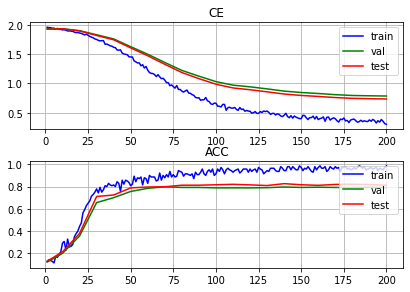

In [11]:
aggregator = trainer_gcn.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

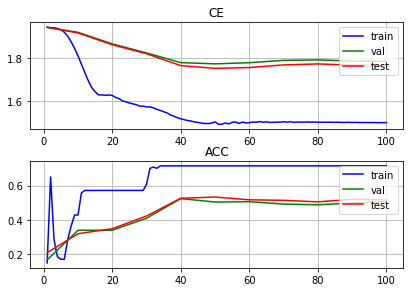

In [12]:
aggregator = trainer_mlp.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])